### Wymagania:
## NA KOŃCU - RAPORTY
1. Należy przygotować sobie bazę danych do klasyfikacji zdjęć (binarną lub
wieloklasową) ✅
2. Wytrenować model na sieci ResNet50 od zera (bez transfer learningu) na CPU
- uzyskane wyniki (czas treningu oraz dokładność) będą stanowić base line
dla kolejnych wyników. ✅
3. W celu optymalizacji szybkości treningu zastosować:
- a. akcelerator GPU - przygotować raport porównawczy z czasem trenowania
bez i z GPU,
- b. transfer learning - przygotować raport porównawczy z transfer
learningiem i bez, interesuje nas tutaj dojście do pewnego poziomu
dokładności np. 80%. ✅
4. W celu optymalizacji dokładności zastosować:
- a. normalizację - przygotować raport porównawczy z normalizacją danych i
bez.
- b. augumentację danych - przygotować raport porównawczy z
augumentacją i bez + informacją jakie przekształcenia zostały
przeprowadzone. ✅ DODAC MALY MODEL BEZ AUGMENTACJI !!
- c. dropout - przygotować raport porównawczy z zastosowaniem dropoutu i
bez.
- d. dokładanie danych - przygotować raport porównawczy z dołożeniem
nowej partii danych i bez. (zrobic oversampling?)
- e. różne rozmiary wejściowe (np. 96x96, 160x160, 224x224) - przygotować
raport porównawczy dla każdego rozmiaru.
- f. różny rozmiar Batch size (np. 32, 64, 128) - przygotować raport
porównawczy dla każdego rozmiaru.
- g. różne struktury sieci (np. VGG16, ResNet101, InceptionV3, MobileNet) -
przygotować raport porównawczy dla każdej sieci (min. 4).

## 0. Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import zipfile
import time
import shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img

## 1. Loading dataset + quick exploration

In [ ]:
! pip install -q kaggle

In [ ]:
# kaggle token
from google.colab import files
files.upload()

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset
with zipfile.ZipFile("augmented-alzheimer-mri-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("alzheimer_dataset")

Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset
License(s): GNU Lesser General Public License 3.0
 90% 342M/380M [00:00<00:00, 631MB/s]
100% 380M/380M [00:00<00:00, 609MB/s]


In [5]:
image_count = len(list(glob.glob('alzheimer_dataset/OriginalDataset/**/*.jpg')))
print(f'{image_count} examples of MRI brain photos in augmented dataset')

6400 examples of MRI brain photos in augmented dataset


In [6]:
base_dir = 'alzheimer_dataset/OriginalDataset'

filepaths = []
labels = []

for label in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label)
    if os.path.isdir(folder_path):
        for fname in os.listdir(folder_path):
            filepaths.append(os.path.join(folder_path, fname))
            labels.append(label)
alzheimer_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

print('Labels and number of photos')
print('-'*10)
print(alzheimer_df["labels"].value_counts())

Labels and number of photos
----------
labels
NonDemented         3200
VeryMildDemented    2240
MildDemented         896
ModerateDemented      64
Name: count, dtype: int64


In [7]:
alzheimer_df.shape

(6400, 2)

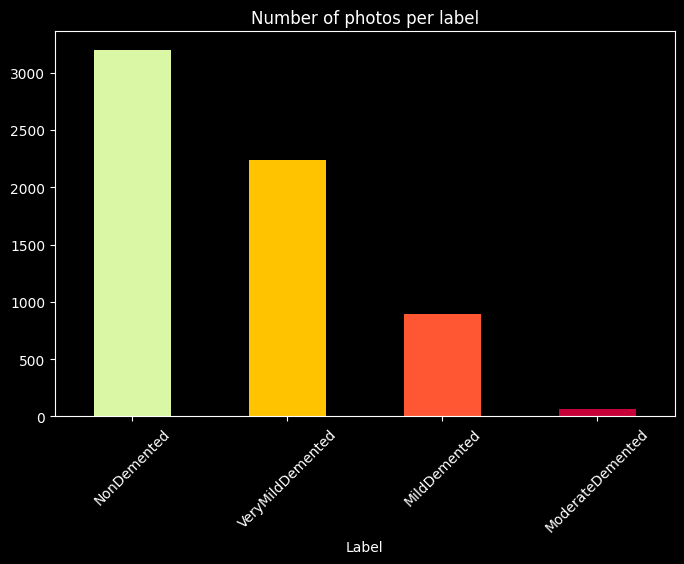

In [ ]:
import matplotlib.pyplot as plt
counts = alzheimer_df['labels'].value_counts()

colors = ['#DAF7A6', '#FFC300', '#FF5733', '#C70039']
counts.plot(kind='bar', color=colors, figsize=(8,5))

plt.title("Number of photos per label")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.style.use('dark_background')
plt.show()

Example of moderate demented brain VS non demented brain from dataset


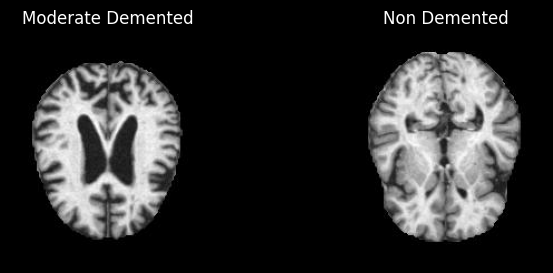

L


In [ ]:
moderate_demented_example = list(glob.glob('alzheimer_dataset/OriginalDataset/ModerateDemented/*'))
non_demented_example = list(glob.glob('alzheimer_dataset/OriginalDataset/NonDemented/*'))
print('Example of moderate demented brain VS non demented brain from dataset')
img_demented = PIL.Image.open(str(moderate_demented_example[5])).convert('L')
img_non_demented = PIL.Image.open(str(non_demented_example[5])).convert('L')
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].imshow(img_demented, cmap='gray')
axs[0].set_title("Moderate Demented")
axs[0].axis('off')

axs[1].imshow(img_non_demented, cmap='gray')
axs[1].set_title("Non Demented")
axs[1].axis('off')

plt.style.use('dark_background')
plt.show()
print(img_demented.mode)

## 4b. Augmentation - classes in this dataset are way too imbalanced, so I am doing this step here to make further training meaningful

In [8]:
img_height = 64
img_width = 64
target_per_class = 2000

original_dataset_dir = 'alzheimer_dataset/OriginalDataset'
augmented_dataset_dir = 'augmented_dataset'
os.makedirs(augmented_dataset_dir, exist_ok=True)

# for MildDemented and ModerateDemented (they have too little images)
classes_to_augment = {
    'ModerateDemented': 'alzheimer_dataset/OriginalDataset/ModerateDemented',
    'MildDemented': 'alzheimer_dataset/OriginalDataset/MildDemented'
}

In [9]:
augmented_base_dir = 'temp'
os.makedirs(augmented_base_dir, exist_ok=True)

augmentor = ImageDataGenerator(
    rotation_range=15, # randomly rotate by 15 degress
    width_shift_range=0.1, # shift horizontally
    height_shift_range=0.1, # shift vertically
    zoom_range=0.2, # zoom 20%
    horizontal_flip=True, # flip horizontally
    fill_mode='nearest' # fills empty pixels (that occur after flipping) on img with nearest pixels
)

for class_name, input_dir in classes_to_augment.items():
    output_dir = os.path.join(augmented_base_dir, class_name)
    os.makedirs(output_dir, exist_ok=True)

    # copy original images
    originals = [f for f in os.listdir(input_dir) if f.lower().endswith('.jpg')]
    for fname in originals:
        src = os.path.join(input_dir, fname)
        dst = os.path.join(output_dir, fname)
        if not os.path.exists(dst):
            img = load_img(src)
            img.save(dst)

    generated = 0
    i = 0
    total_samples_needed = max(0, target_per_class - len(originals))

    while generated < total_samples_needed:
        img_path = os.path.join(input_dir, originals[i % len(originals)])
        img = load_img(img_path, target_size=(img_height, img_width))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0) # batch

        for batch in augmentor.flow(x, batch_size=1):
            aug_path = os.path.join(output_dir, f"aug_{generated}.jpg")
            save_img(aug_path, batch[0])
            generated += 1
            break  # after image has been augmented

In [10]:
# results of augmentation (should be 2000 samples each class)
base_dir = 'temp'

filepaths = []
labels = []

for label in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label)
    if os.path.isdir(folder_path):
        for fname in os.listdir(folder_path):
            filepaths.append(os.path.join(folder_path, fname))
            labels.append(label)
alzheimer_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

print('Labels and number of photos')
print('-'*10)
print(alzheimer_df["labels"].value_counts())

Labels and number of photos
----------
labels
ModerateDemented    2000
MildDemented        2000
Name: count, dtype: int64


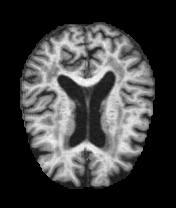

In [12]:
mild_d = list(glob.glob('temp/MildDemented/*'))
PIL.Image.open(str(mild_d[1600]))

In [13]:
# merge datasets
import shutil
import os

original_dirs = {
    'NonDemented': 'alzheimer_dataset/OriginalDataset/NonDemented',
    'VeryMildDemented': 'alzheimer_dataset/OriginalDataset/VeryMildDemented',
}
augmented_dirs = {
    'MildDemented': 'temp/MildDemented',
    'ModerateDemented': 'temp/ModerateDemented',
}

final_base = 'augmented_ds'

def copy_images(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    for fname in os.listdir(src_dir):
        if fname.lower().endswith(('.jpg')):
            src = os.path.join(src_dir, fname)
            dst = os.path.join(dst_dir, fname)
            shutil.copy(src, dst)

for label, path in original_dirs.items():
    copy_images(path, os.path.join(final_base, label))

for label, path in augmented_dirs.items():
    copy_images(path, os.path.join(final_base, label))

In [14]:
base_dir = 'augmented_ds'

filepaths = []
labels = []

for label in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label)
    if os.path.isdir(folder_path):
        for fname in os.listdir(folder_path):
            filepaths.append(os.path.join(folder_path, fname))
            labels.append(label)
alzheimer_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

print('Labels and number of photos')
print('-'*10)
print(alzheimer_df["labels"].value_counts())

Labels and number of photos
----------
labels
NonDemented         3200
VeryMildDemented    2240
ModerateDemented    2000
MildDemented        2000
Name: count, dtype: int64


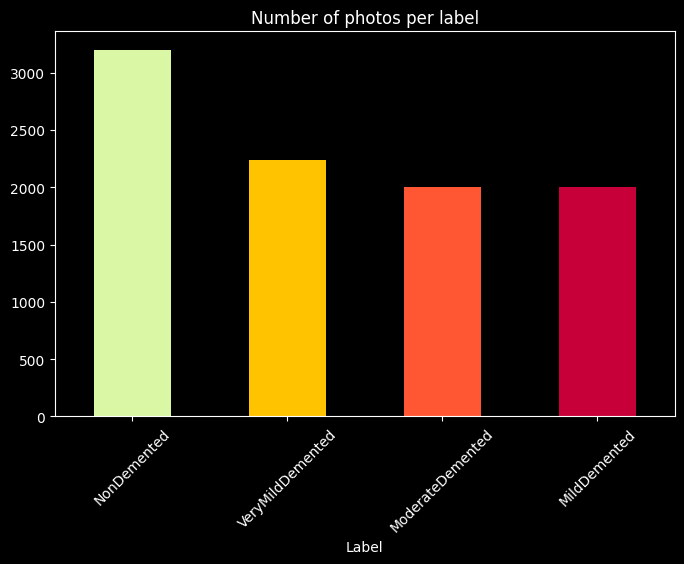

In [ ]:
counts = alzheimer_df['labels'].value_counts()

colors = ['#DAF7A6', '#FFC300', '#FF5733', '#C70039']
counts.plot(kind='bar', color=colors, figsize=(8,5))

plt.title("Number of photos per label")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.style.use('dark_background')
plt.show()

## 2. ResNet50 without transfer learning on CPU

In [19]:
batch_size = 32
class_count = 4

In [ ]:
small_df = alzheimer_df.sample(n=5000, random_state=42) # training on 5000 samples because im not waiting 3 days
train_val_set, test_set = train_test_split(
    small_df,
    test_size=0.2,
    stratify=small_df['labels'],
    random_state=42)

train_set, val_set = train_test_split(
    train_val_set,
    test_size=0.2,
    stratify=train_val_set['labels'],
    random_state=42)

print(f"Number of training samples: {len(train_set)}")
print(f"Number of validation samples: {len(val_set)}")
print(f"Number of testing samples: {len(test_set)}")

Number of training samples: 3200
Number of validation samples: 800
Number of testing samples: 1000


In [ ]:
img_gen = ImageDataGenerator() # makes it possible to load images in batches rather than all at once
train_generator = img_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width), # changing size for faster training
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3200 validated image filenames belonging to 4 classes.
Found 800 validated image filenames belonging to 4 classes.


In [ ]:
test_generator = img_gen.flow_from_dataframe(
    dataframe=test_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1000 validated image filenames belonging to 4 classes.


In [ ]:
input_shape = (img_height, img_width, 3) # image input size
resnet50_base_model = ResNet50(include_top=False,
                         weights=None, # no transfer learning
                         classes=class_count,
                         input_shape=input_shape)

x = resnet50_base_model.output
x = GlobalAveragePooling2D()(x) # what the siet
outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 535s 5s/step - accuracy: 0.5038 - loss: 1.5179 - val_accuracy: 0.2087 - val_loss: 3.5019
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 488s 5s/step - accuracy: 0.7127 - loss: 0.7174 - val_accuracy: 0.4338 - val_loss: 1.8393
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 484s 5s/step - accuracy: 0.7490 - loss: 0.5804 - val_accuracy: 0.7025 - val_loss: 0.8339
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 489s 5s/step - accuracy: 0.8286 - loss: 0.4395 - val_accuracy: 0.7088 - val_loss: 0.6123
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 517s 5s/step - accuracy: 0.8588 - loss: 0.3775 - val_accuracy: 0.6250 - val_loss: 1.4226
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 509s 5s/step - accuracy: 0.8870 - loss: 0.2959 - val_accuracy: 0.7450 - val_loss: 0.9640
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 506s 5s/step - accuracy: 0.8697 - loss: 0.3505 - val_accuracy: 0.7387 - val_loss: 0.9940
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 511s 5s/step - accuracy: 0.8909 - loss: 0.2934 - val_accuracy: 0.765

In [ ]:
resnet50_base_training_time = training_end_time - training_start_time
test_loss, resnet50_base_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_base_accuracy:.4f}')
print(f'Training took {resnet50_base_training_time / 60:.2f} minutes')

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 449ms/step - accuracy: 0.6973 - loss: 1.0006
--------------------------------------------------
Test accuracy: 0.6960
Training took 84.25 minutes


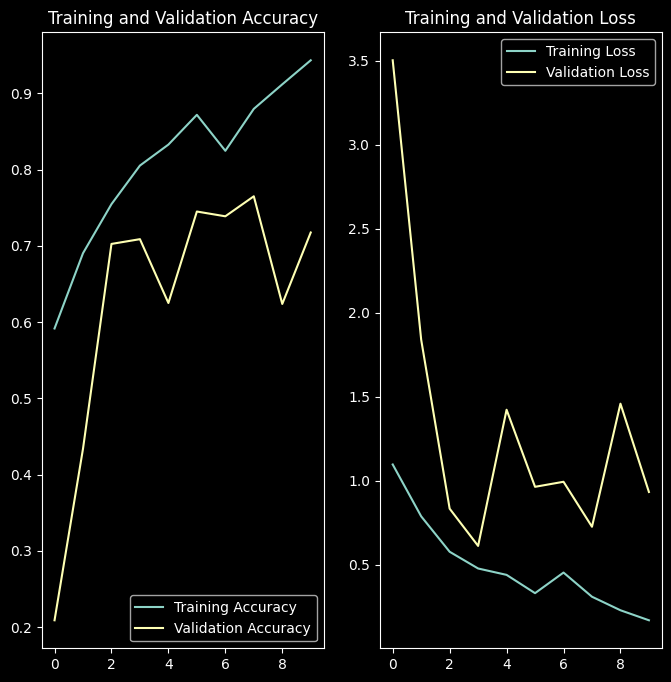

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

## 3a. ResNet50 without transfer learning on GPU

In [ ]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 94ms/step - accuracy: 0.4861 - loss: 1.5733 - val_accuracy: 0.3212 - val_loss: 1.9947
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.7257 - loss: 0.6747 - val_accuracy: 0.3075 - val_loss: 2.5390
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.7765 - loss: 0.5489 - val_accuracy: 0.3775 - val_loss: 1.7741
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.7587 - loss: 0.6257 - val_accuracy: 0.6300 - val_loss: 1.5592
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.7806 - loss: 0.5857 - val_accuracy: 0.6812 - val_loss: 1.2331
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.8613 - loss: 0.3801 - val_accuracy: 0.6938 - val_loss: 1.2065
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8911 - loss: 0.2758 - val_accuracy: 0.7088 - val_loss: 0.9357
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9146 - loss: 0.2503 - val_accuracy: 0

In [ ]:
resnet50_gpu_training_time = training_end_time - training_start_time
test_loss, resnet50_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_gpu_accuracy:.4f}')
print(f'Training took {resnet50_gpu_training_time / 60:.2f} minutes')

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.7790 - loss: 0.6854
--------------------------------------------------
Test accuracy: 0.7810
Training took 2.16 minutes


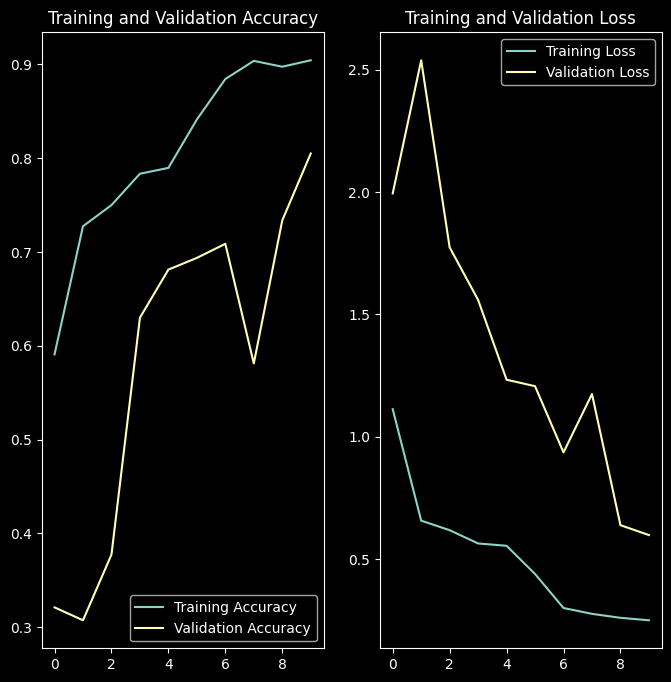

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

## 3b. ResNet50 with transfer learning on GPU

In [ ]:
input_shape = (img_height, img_width, 3)
resnet50_transferlearning_model = ResNet50(include_top=False,
                         weights='imagenet', # transfer learning
                         classes=class_count,
                         input_shape=input_shape)
resnet50_transferlearning_model.trainable = False

x = resnet50_transferlearning_model.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_transferlearning_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.5570 - loss: 1.0464 - val_accuracy: 0.6862 - val_loss: 0.7003
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6873 - loss: 0.6980 - val_accuracy: 0.6862 - val_loss: 0.6677
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7136 - loss: 0.6397 - val_accuracy: 0.6988 - val_loss: 0.6363
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7200 - loss: 0.6053 - val_accuracy: 0.7387 - val_loss: 0.6111
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7639 - loss: 0.5375 - val_accuracy: 0.7387 - val_loss: 0.5742
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7428 - loss: 0.5733 - val_accuracy: 0.7312 - val_loss: 0.5989
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7730 - loss: 0.5105 - val_accuracy: 0.7525 - val_loss: 0.5554
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7834 - loss: 0.4907 - val_acc

In [ ]:
resnet50_tl_training_time = training_end_time - training_start_time
test_loss, resnet50_tl_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_tl_accuracy:.4f}')
print(f'Training took {resnet50_tl_training_time / 60:.2f} minutes')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7460 - loss: 0.5678
--------------------------------------------------
Test accuracy: 0.7430
Training took 0.69 minutes


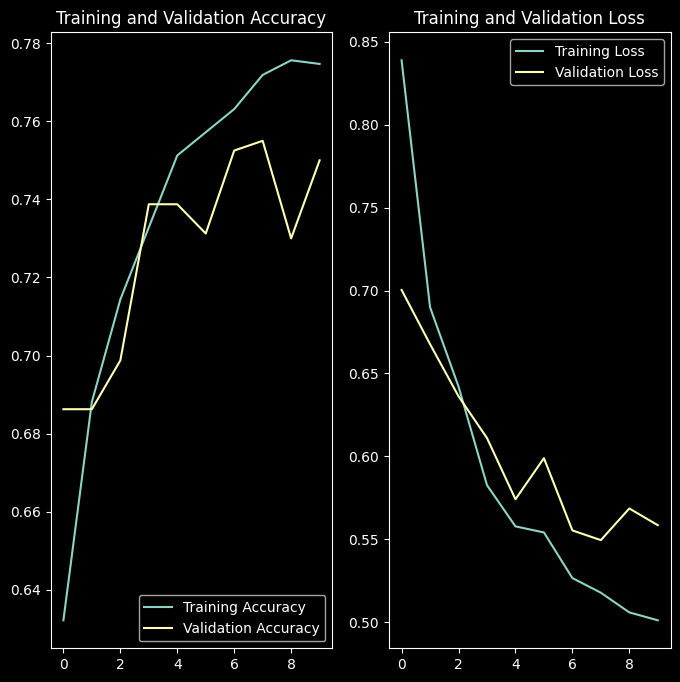

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

## Same model, but without augmentation

In [ ]:
base_dir = 'alzheimer_dataset/OriginalDataset'

filepaths = []
labels = []

for label in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label)
    if os.path.isdir(folder_path):
        for fname in os.listdir(folder_path):
            filepaths.append(os.path.join(folder_path, fname))
            labels.append(label)
alzheimer_df_0 = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

small_df_0 = alzheimer_df_0.sample(n=5000, random_state=42)
train_val_set_0, test_set_0 = train_test_split(
    small_df_0,
    test_size=0.2,
    stratify=small_df['labels'],
    random_state=42)

train_set_0, val_set_0 = train_test_split(
    train_val_set_0,
    test_size=0.2,
    stratify=train_val_set_0['labels'],
    random_state=42)

img_gen = ImageDataGenerator() # makes it possible to load images in batches rather than all at once
train_generator_0 = img_gen.flow_from_dataframe(
    dataframe=train_set_0,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width), # changing size for faster training
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator_0 = img_gen.flow_from_dataframe(
    dataframe=val_set_0,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator_0 = img_gen.flow_from_dataframe(
    dataframe=test_set_0,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

input_shape = (img_height, img_width, 3)
not_augmented = ResNet50(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
not_augmented.trainable = False

x = not_augmented.output
x = GlobalAveragePooling2D()(x)
outputs_0 = Dense(class_count, activation='softmax')(x)
model_not_augmented = Model(inputs=not_augmented.input, outputs=outputs_0)

model_not_augmented.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Found 3200 validated image filenames belonging to 4 classes.
Found 800 validated image filenames belonging to 4 classes.
Found 1000 validated image filenames belonging to 4 classes.


In [ ]:
training_start_time = time.time()
history_0 = model_not_augmented.fit(train_generator_0,
                    validation_data = val_generator_0,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.4717 - loss: 1.2677 - val_accuracy: 0.5612 - val_loss: 1.0105
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5822 - loss: 0.9248 - val_accuracy: 0.5700 - val_loss: 0.9006
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5978 - loss: 0.8664 - val_accuracy: 0.5838 - val_loss: 0.8790
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6240 - loss: 0.8274 - val_accuracy: 0.6050 - val_loss: 0.8361
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6697 - loss: 0.7698 - val_accuracy: 0.6237 - val_loss: 0.8428
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6526 - loss: 0.7667 - val_accuracy: 0.6112 - val_loss: 0.8248
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6727 - loss: 0.7346 - val_accuracy: 0.5838 - val_loss: 0.9078
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6511 - loss: 0.7513 - val_accuracy: 0.63

In [ ]:
not_augmented_time = training_end_time - training_start_time
test_loss, na_accuracy = model_not_augmented.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {na_accuracy:.4f}')
print(f'Training took {not_augmented_time / 60:.2f} minutes')

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.5027 - loss: 1.5891
--------------------------------------------------
Test accuracy: 0.5140
Training took 0.73 minutes


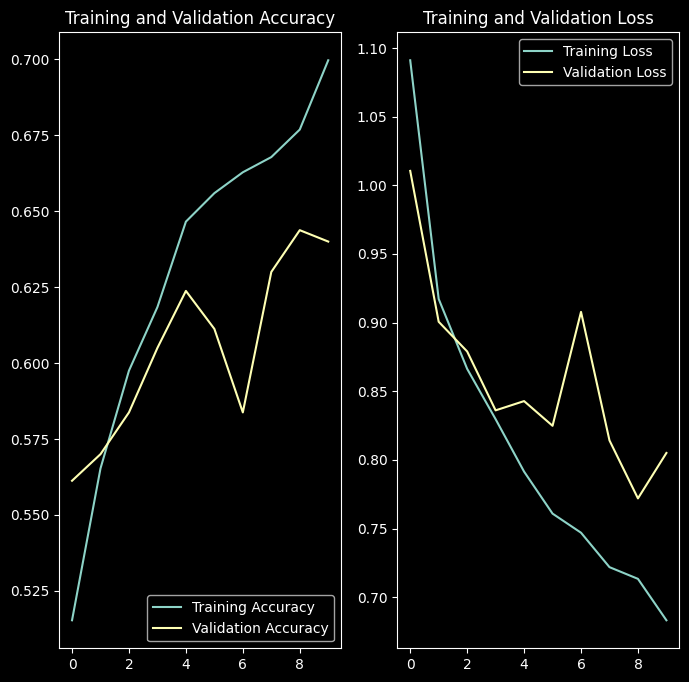

In [ ]:
acc = history_0.history['accuracy']
val_acc = history_0.history['val_accuracy']

loss = history_0.history['loss']
val_loss = history_0.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

## 4a. Normalization

In [16]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [17]:
img_height = 64
img_width = 64
class_count = 4

In [20]:
small_df = alzheimer_df.sample(n=5000, random_state=42)
train_val_set, test_set = train_test_split(
    small_df,
    test_size=0.2,
    stratify=small_df['labels'],
    random_state=42)

train_set, val_set = train_test_split(
    train_val_set,
    test_size=0.2,
    stratify=train_val_set['labels'],
    random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

img_gen = ImageDataGenerator()
train_generator = img_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = img_gen.flow_from_dataframe(
    dataframe=test_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3200 validated image filenames belonging to 4 classes.
Found 800 validated image filenames belonging to 4 classes.
Found 1000 validated image filenames belonging to 4 classes.


In [30]:
input_shape = (img_height, img_width, 3)
resnet50_base_model = ResNet50(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
resnet50_base_model.trainable = False
x = resnet50_base_model.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - accuracy: 0.6241 - loss: 0.8384 - val_accuracy: 0.7048 - val_loss: 0.6183
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.7352 - loss: 0.5774 - val_accuracy: 0.7062 - val_loss: 0.6088
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.7658 - loss: 0.5365 - val_accuracy: 0.7287 - val_loss: 0.5764
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.7639 - loss: 0.5116 - val_accuracy: 0.7485 - val_loss: 0.5423
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.7935 - loss: 0.4780 - val_accuracy: 0.7505 - val_loss: 0.5469
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.7905 - loss: 0.4748 - val_accuracy: 0.7651 - val_loss: 0.5139
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.7978 - loss: 0.4470 - val_accuracy: 0.7664 - val_loss: 0.4981
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.8061 - loss: 0.4356 -

In [32]:
resnet50_normalized_time = training_end_time - training_start_time
test_loss, resnet50_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_gpu_accuracy:.4f}')
print(f'Training took {resnet50_normalized_time / 60:.2f} minutes')

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8147 - loss: 0.4333
--------------------------------------------------
Test accuracy: 0.7871
Training took 2.78 minutes


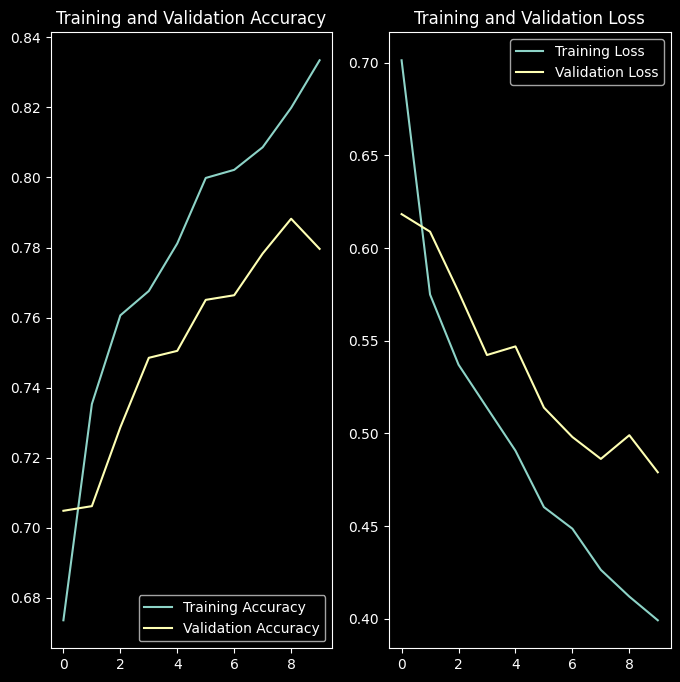

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

## 4c. Dropout

In [23]:
from tensorflow.keras.layers import Dropout

In [35]:
input_shape = (img_height, img_width, 3)
resnet50_base_model = ResNet50(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
resnet50_base_model.trainable = False
x = resnet50_base_model.output
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x) # half of neurons in a layer will be turned off randomly

outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 35s 130ms/step - accuracy: 0.5311 - loss: 1.3277 - val_accuracy: 0.6830 - val_loss: 0.6568
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.6751 - loss: 0.7552 - val_accuracy: 0.7167 - val_loss: 0.6016
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.6950 - loss: 0.6802 - val_accuracy: 0.7148 - val_loss: 0.6101
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.7000 - loss: 0.6493 - val_accuracy: 0.7386 - val_loss: 0.5840
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.7297 - loss: 0.6243 - val_accuracy: 0.7187 - val_loss: 0.5961
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.7146 - loss: 0.6192 - val_accuracy: 0.7194 - val_loss: 0.5969
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.7306 - loss: 0.5961 - val_accuracy: 0.7531 - val_loss: 0.5517
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.7408 - loss: 0.5707 -

In [37]:
resnet50_normalized_time = training_end_time - training_start_time
test_loss, resnet50_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_gpu_accuracy:.4f}')
print(f'Training took {resnet50_normalized_time / 60:.2f} minutes')

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7414 - loss: 0.5302
--------------------------------------------------
Test accuracy: 0.7278
Training took 2.90 minutes


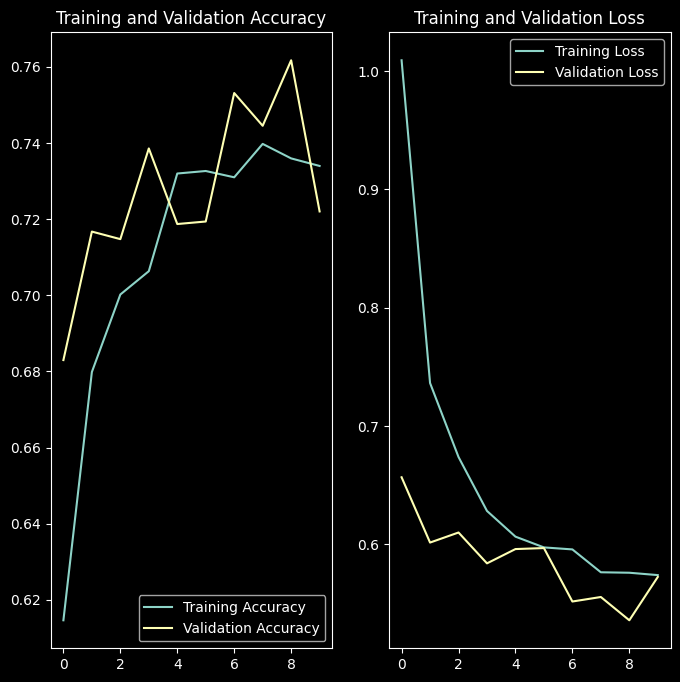

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

## 4d. Adding data (using whole dataset instead of samples :) )

In [39]:
train_val_set, test_set = train_test_split(
    alzheimer_df,
    test_size=0.2,
    stratify=alzheimer_df['labels'],
    random_state=42)

train_set, val_set = train_test_split(
    train_val_set,
    test_size=0.2,
    stratify=train_val_set['labels'],
    random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

img_gen = ImageDataGenerator()
train_generator = img_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = img_gen.flow_from_dataframe(
    dataframe=test_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 6041 validated image filenames belonging to 4 classes.
Found 1511 validated image filenames belonging to 4 classes.
Found 1888 validated image filenames belonging to 4 classes.


In [40]:
input_shape = (img_height, img_width, 3)
resnet50_base_model = ResNet50(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
resnet50_base_model.trainable = False
x = resnet50_base_model.output
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)

outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 31s 106ms/step - accuracy: 0.5362 - loss: 1.2741 - val_accuracy: 0.6936 - val_loss: 0.6945
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.6778 - loss: 0.7507 - val_accuracy: 0.7035 - val_loss: 0.6208
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.7102 - loss: 0.6531 - val_accuracy: 0.7300 - val_loss: 0.5849
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.7313 - loss: 0.6236 - val_accuracy: 0.7399 - val_loss: 0.5772
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.7192 - loss: 0.6170 - val_accuracy: 0.7300 - val_loss: 0.5775
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.7247 - loss: 0.6065 - val_accuracy: 0.7399 - val_loss: 0.5671
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.7441 - loss: 0.5688 - val_accuracy: 0.7432 - val_loss: 0.5700
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.7344 - loss: 0.5925 - val_accura

In [42]:
resnet50_whole= training_end_time - training_start_time
test_loss, resnet50_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_gpu_accuracy:.4f}')
print(f'Training took {resnet50_whole / 60:.2f} minutes')

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7497 - loss: 0.5247
--------------------------------------------------
Test accuracy: 0.7309
Training took 2.73 minutes


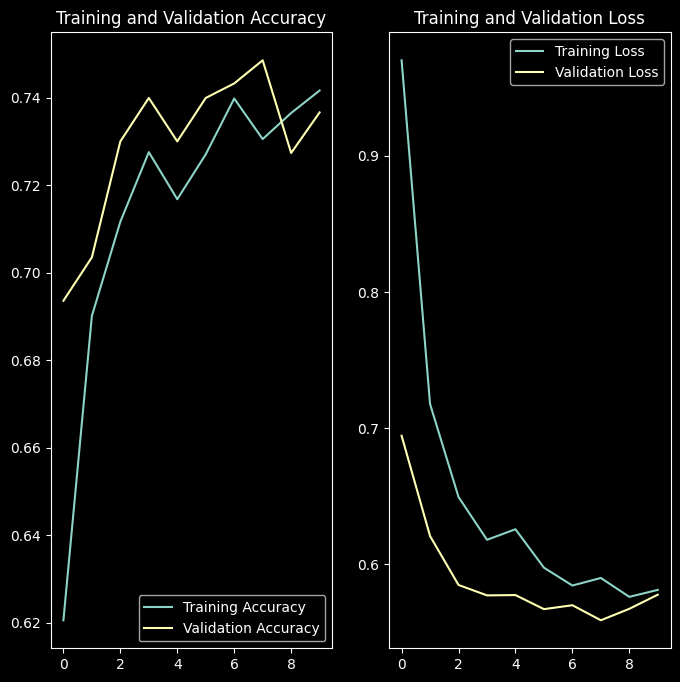

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

## 4e. Different input sizes

### 96x96

In [115]:
img_height = 96
img_width = 96

In [116]:
train_val_set, test_set = train_test_split(
    alzheimer_df,
    test_size=0.2,
    stratify=alzheimer_df['labels'],
    random_state=42)

train_set, val_set = train_test_split(
    train_val_set,
    test_size=0.2,
    stratify=train_val_set['labels'],
    random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

img_gen = ImageDataGenerator()
train_generator = img_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = img_gen.flow_from_dataframe(
    dataframe=test_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

input_shape = (img_height, img_width, 3)
resnet50_base_model = ResNet50(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
resnet50_base_model.trainable = False
x = resnet50_base_model.output
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)

outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Found 6041 validated image filenames belonging to 4 classes.
Found 1511 validated image filenames belonging to 4 classes.
Found 1888 validated image filenames belonging to 4 classes.


In [117]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 28s 82ms/step - accuracy: 0.5473 - loss: 1.4708 - val_accuracy: 0.6459 - val_loss: 0.7779
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6582 - loss: 0.8468 - val_accuracy: 0.6876 - val_loss: 0.6537
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.6790 - loss: 0.7271 - val_accuracy: 0.6870 - val_loss: 0.6595
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7061 - loss: 0.6572 - val_accuracy: 0.6982 - val_loss: 0.6793
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.7152 - loss: 0.6512 - val_accuracy: 0.6664 - val_loss: 0.7407
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7055 - loss: 0.6529 - val_accuracy: 0.7055 - val_loss: 0.6080
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7261 - loss: 0.6190 - val_accuracy: 0.6876 - val_loss: 0.6477
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.7180 - loss: 0.6319 - val_accuracy: 0.71

In [118]:
resnet50 = training_end_time - training_start_time
test_loss, resnet50_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_gpu_accuracy:.4f}')
print(f'Training took {resnet50 / 60:.2f} minutes')

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7650 - loss: 0.5156
--------------------------------------------------
Test accuracy: 0.7526
Training took 1.38 minutes


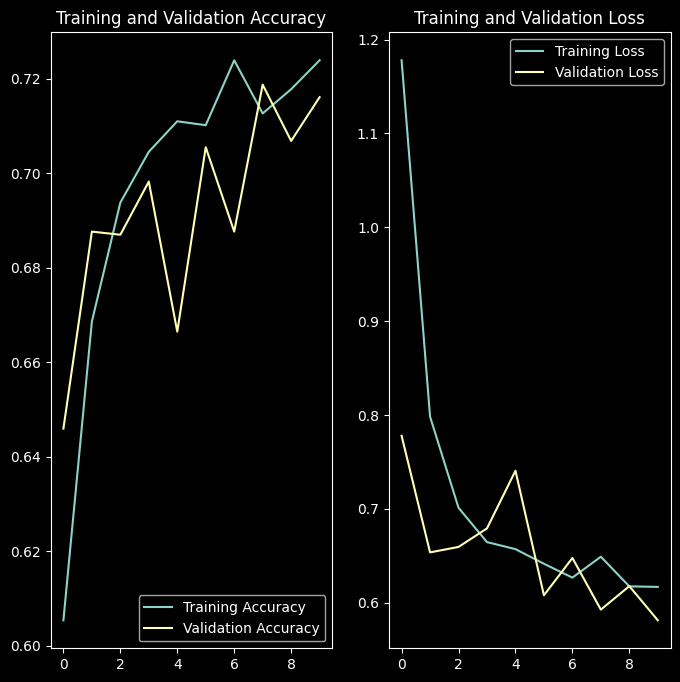

In [120]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

### 160x160

In [121]:
img_height = 160
img_width = 160

In [124]:
train_val_set, test_set = train_test_split(
    alzheimer_df,
    test_size=0.2,
    stratify=alzheimer_df['labels'],
    random_state=42)

train_set, val_set = train_test_split(
    train_val_set,
    test_size=0.2,
    stratify=train_val_set['labels'],
    random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

img_gen = ImageDataGenerator()
train_generator = img_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = img_gen.flow_from_dataframe(
    dataframe=test_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

input_shape = (img_height, img_width, 3)
resnet50_base_model = ResNet50(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
resnet50_base_model.trainable = False
x = resnet50_base_model.output
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)

outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Found 6041 validated image filenames belonging to 4 classes.
Found 1511 validated image filenames belonging to 4 classes.
Found 1888 validated image filenames belonging to 4 classes.


In [125]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - accuracy: 0.5728 - loss: 1.2118 - val_accuracy: 0.6929 - val_loss: 0.6568
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.6695 - loss: 0.7644 - val_accuracy: 0.7128 - val_loss: 0.6112
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.6961 - loss: 0.6708 - val_accuracy: 0.7081 - val_loss: 0.6180
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.7116 - loss: 0.6377 - val_accuracy: 0.7300 - val_loss: 0.5937
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.7194 - loss: 0.5966 - val_accuracy: 0.7333 - val_loss: 0.5705
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.7193 - loss: 0.6053 - val_accuracy: 0.7313 - val_loss: 0.5908
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.7248 - loss: 0.6011 - val_accuracy: 0.7419 - val_loss: 0.5534
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.7355 - loss: 0.5828 - val_accura

In [126]:
resnet50 = training_end_time - training_start_time
test_loss, resnet50_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_gpu_accuracy:.4f}')
print(f'Training took {resnet50 / 60:.2f} minutes')

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7232 - loss: 0.5626
--------------------------------------------------
Test accuracy: 0.7097
Training took 2.34 minutes


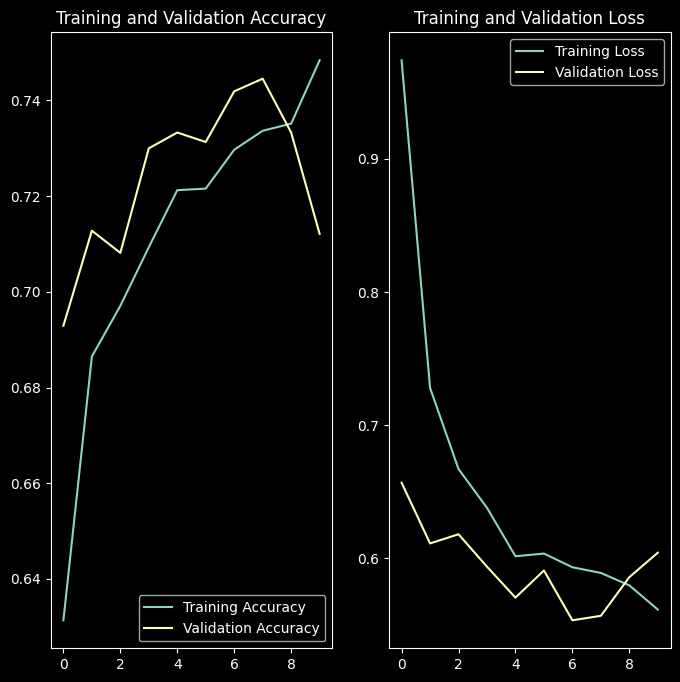

In [127]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

In [ ]:
# fixed:)

### 224x224

In [128]:
img_height = 224
img_width = 224

In [129]:
train_val_set, test_set = train_test_split(
    alzheimer_df,
    test_size=0.2,
    stratify=alzheimer_df['labels'],
    random_state=42)

train_set, val_set = train_test_split(
    train_val_set,
    test_size=0.2,
    stratify=train_val_set['labels'],
    random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

img_gen = ImageDataGenerator()
train_generator = img_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = img_gen.flow_from_dataframe(
    dataframe=test_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

input_shape = (img_height, img_width, 3)
resnet50_base_model = ResNet50(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
resnet50_base_model.trainable = False
x = resnet50_base_model.output
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)

outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Found 6041 validated image filenames belonging to 4 classes.
Found 1511 validated image filenames belonging to 4 classes.
Found 1888 validated image filenames belonging to 4 classes.


In [130]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 38s 149ms/step - accuracy: 0.5518 - loss: 1.1979 - val_accuracy: 0.6956 - val_loss: 0.6622
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - accuracy: 0.6956 - loss: 0.7077 - val_accuracy: 0.7009 - val_loss: 0.6308
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.7042 - loss: 0.6514 - val_accuracy: 0.7207 - val_loss: 0.6093
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.7224 - loss: 0.6139 - val_accuracy: 0.7287 - val_loss: 0.5765
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.7426 - loss: 0.5865 - val_accuracy: 0.7194 - val_loss: 0.5748
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.7309 - loss: 0.5655 - val_accuracy: 0.7280 - val_loss: 0.5836
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.7331 - loss: 0.5808 - val_accuracy: 0.7399 - val_loss: 0.5543
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.7481 - loss: 0.5450 - val

In [131]:
resnet50 = training_end_time - training_start_time
test_loss, resnet50_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_gpu_accuracy:.4f}')
print(f'Training took {resnet50 / 60:.2f} minutes')

59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.7759 - loss: 0.4809
--------------------------------------------------
Test accuracy: 0.7553
Training took 3.78 minutes


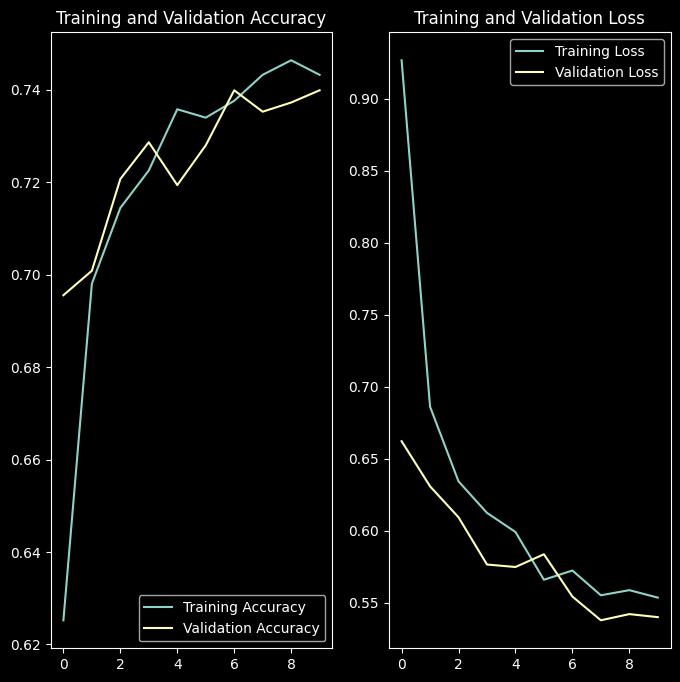

In [132]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

## 4f. Different batch sizes (16x64, 64x64, 128x128)

In [133]:
# smaller images, because i dont have that much memory to use bigger uses in bigger batches
img_height = 112
img_width = 112

### Batch_size = 16

In [134]:
batch_size = 16

In [135]:
train_val_set, test_set = train_test_split(
    alzheimer_df,
    test_size=0.2,
    stratify=alzheimer_df['labels'],
    random_state=42)

train_set, val_set = train_test_split(
    train_val_set,
    test_size=0.2,
    stratify=train_val_set['labels'],
    random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

img_gen = ImageDataGenerator()
train_generator = img_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = img_gen.flow_from_dataframe(
    dataframe=test_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

input_shape = (img_height, img_width, 3)
resnet50_base_model = ResNet50(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
resnet50_base_model.trainable = False
x = resnet50_base_model.output
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)

outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Found 6041 validated image filenames belonging to 4 classes.
Found 1511 validated image filenames belonging to 4 classes.
Found 1888 validated image filenames belonging to 4 classes.


In [63]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


378/378 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.5582 - loss: 1.2531 - val_accuracy: 0.6936 - val_loss: 0.6373
Epoch 2/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.6724 - loss: 0.7526 - val_accuracy: 0.6724 - val_loss: 0.7004
Epoch 3/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6848 - loss: 0.7039 - val_accuracy: 0.6717 - val_loss: 0.6830
Epoch 4/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.7088 - loss: 0.6375 - val_accuracy: 0.6744 - val_loss: 0.6724
Epoch 5/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6942 - loss: 0.6859 - val_accuracy: 0.7194 - val_loss: 0.6034
Epoch 6/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7081 - loss: 0.6376 - val_accuracy: 0.7419 - val_loss: 0.5575
Epoch 7/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7237 - loss: 0.6354 - val_accuracy: 0.7280 - val_loss: 0.5726
Epoch 8/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.7191 - loss: 0.6261 - val_accuracy: 

In [71]:
resnet50 = training_end_time - training_start_time
test_loss, resnet50_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_gpu_accuracy:.4f}')
print(f'Training took {resnet50 / 60:.2f} minutes')

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.7515 - loss: 0.5438
--------------------------------------------------
Test accuracy: 0.7521
Training took 1.64 minutes


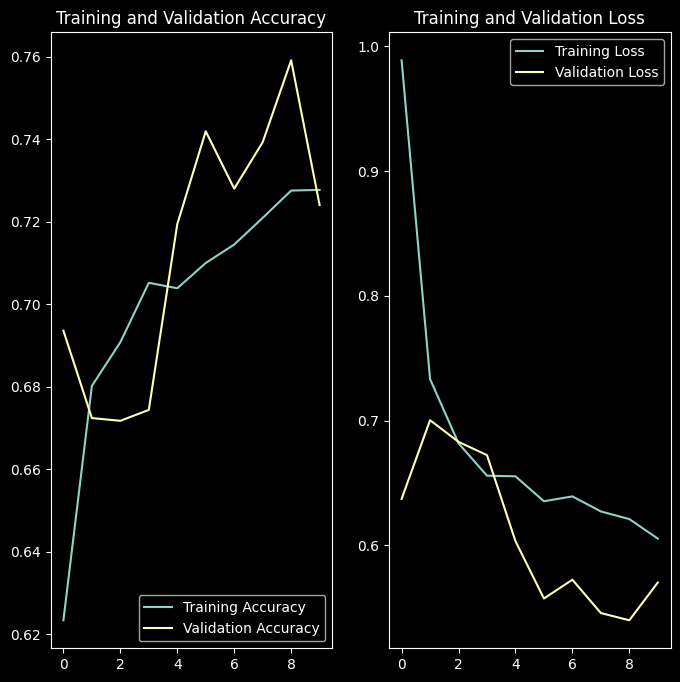

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

### Batch_size = 64

In [136]:
batch_size = 64

In [138]:
train_val_set, test_set = train_test_split(
    alzheimer_df,
    test_size=0.2,
    stratify=alzheimer_df['labels'],
    random_state=42)

train_set, val_set = train_test_split(
    train_val_set,
    test_size=0.2,
    stratify=train_val_set['labels'],
    random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

img_gen = ImageDataGenerator()
train_generator = img_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = img_gen.flow_from_dataframe(
    dataframe=test_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

input_shape = (img_height, img_width, 3)
resnet50_base_model = ResNet50(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
resnet50_base_model.trainable = False
x = resnet50_base_model.output
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)

outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Found 6041 validated image filenames belonging to 4 classes.
Found 1511 validated image filenames belonging to 4 classes.
Found 1888 validated image filenames belonging to 4 classes.


In [139]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.5193 - loss: 1.3829 - val_accuracy: 0.6711 - val_loss: 0.6747
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.6589 - loss: 0.8160 - val_accuracy: 0.6876 - val_loss: 0.6475
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.7017 - loss: 0.6792 - val_accuracy: 0.7062 - val_loss: 0.6211
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.6983 - loss: 0.6625 - val_accuracy: 0.7194 - val_loss: 0.6039
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.7038 - loss: 0.6459 - val_accuracy: 0.6797 - val_loss: 0.6403
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.7063 - loss: 0.6302 - val_accuracy: 0.7320 - val_loss: 0.5891
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.7152 - loss: 0.6116 - val_accuracy: 0.7465 - val_loss: 0.5749
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.7362 - loss: 0.5759 - val_accuracy: 0.7392 - val_loss:

In [140]:
resnet50 = training_end_time - training_start_time
test_loss, resnet50_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_gpu_accuracy:.4f}')
print(f'Training took {resnet50 / 60:.2f} minutes')

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.7658 - loss: 0.5363
--------------------------------------------------
Test accuracy: 0.7537
Training took 1.60 minutes


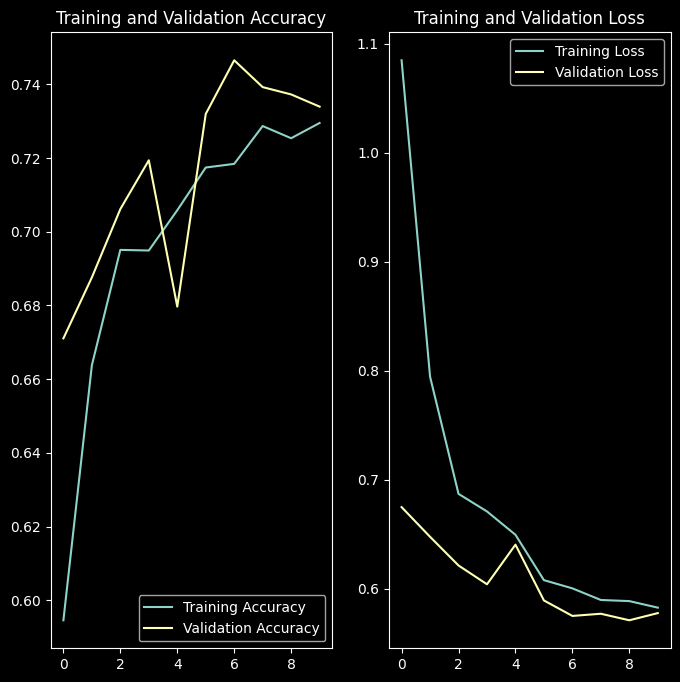

In [141]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

### Batch_size = 128

In [142]:
batch_size = 128

In [143]:
train_val_set, test_set = train_test_split(
    alzheimer_df,
    test_size=0.2,
    stratify=alzheimer_df['labels'],
    random_state=42)

train_set, val_set = train_test_split(
    train_val_set,
    test_size=0.2,
    stratify=train_val_set['labels'],
    random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

img_gen = ImageDataGenerator()
train_generator = img_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = img_gen.flow_from_dataframe(
    dataframe=test_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

input_shape = (img_height, img_width, 3)
resnet50_base_model = ResNet50(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
resnet50_base_model.trainable = False
x = resnet50_base_model.output
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)

outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Found 6041 validated image filenames belonging to 4 classes.
Found 1511 validated image filenames belonging to 4 classes.
Found 1888 validated image filenames belonging to 4 classes.


In [76]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 364ms/step - accuracy: 0.4529 - loss: 1.8365 - val_accuracy: 0.6731 - val_loss: 0.7118
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.6345 - loss: 0.9637 - val_accuracy: 0.6803 - val_loss: 0.7040
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.6749 - loss: 0.8045 - val_accuracy: 0.6837 - val_loss: 0.6495
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - accuracy: 0.6760 - loss: 0.7244 - val_accuracy: 0.6982 - val_loss: 0.6403
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.7014 - loss: 0.6546 - val_accuracy: 0.7062 - val_loss: 0.6103
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.7167 - loss: 0.6365 - val_accuracy: 0.7201 - val_loss: 0.6066
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.7108 - loss: 0.6366 - val_accuracy: 0.7214 - val_loss: 0.5973
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.7128 - loss: 0.5997 - val_accuracy: 0

In [77]:
resnet50 = training_end_time - training_start_time
test_loss, resnet50_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_gpu_accuracy:.4f}')
print(f'Training took {resnet50 / 60:.2f} minutes')

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 405ms/step - accuracy: 0.7073 - loss: 0.6102
--------------------------------------------------
Test accuracy: 0.7029
Training took 1.55 minutes


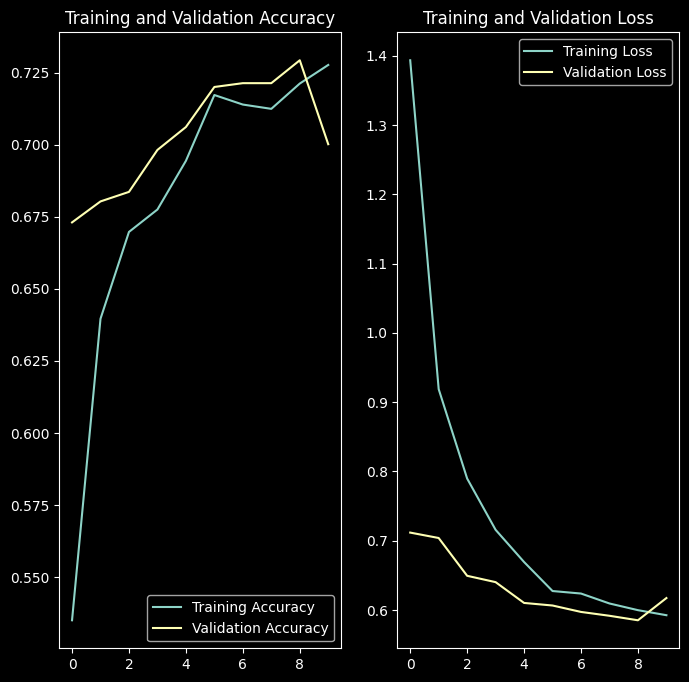

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

### 4g. Different structures (VGG16, RenNet101, InceptionV3, MobileNet)

In [92]:
img_height = 224
img_width = 224
batch_size = 32 # best results

In [93]:
train_val_set, test_set = train_test_split(
    alzheimer_df,
    test_size=0.2,
    stratify=alzheimer_df['labels'],
    random_state=42)

train_set, val_set = train_test_split(
    train_val_set,
    test_size=0.2,
    stratify=train_val_set['labels'],
    random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

img_gen = ImageDataGenerator()
train_generator = img_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = img_gen.flow_from_dataframe(
    dataframe=test_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 6041 validated image filenames belonging to 4 classes.
Found 1511 validated image filenames belonging to 4 classes.
Found 1888 validated image filenames belonging to 4 classes.


### VGG16

In [94]:
from tensorflow.keras.applications import VGG16

In [95]:
input_shape = (img_height, img_width, 3)
base_model = VGG16(include_top=False,
                   weights='imagenet',
                   input_shape=input_shape)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 76s 335ms/step - accuracy: 0.4474 - loss: 4.9260 - val_accuracy: 0.6651 - val_loss: 1.2532
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 39s 208ms/step - accuracy: 0.6109 - loss: 1.6753 - val_accuracy: 0.6757 - val_loss: 0.8385
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 208ms/step - accuracy: 0.6568 - loss: 1.0342 - val_accuracy: 0.6956 - val_loss: 0.7405
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 39s 205ms/step - accuracy: 0.6969 - loss: 0.7999 - val_accuracy: 0.7174 - val_loss: 0.6301
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 39s 204ms/step - accuracy: 0.6815 - loss: 0.7318 - val_accuracy: 0.7015 - val_loss: 0.6287
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 42s 209ms/step - accuracy: 0.7017 - loss: 0.7051 - val_accuracy: 0.7108 - val_loss: 0.6346
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 39s 207ms/step - accuracy: 0.7052 - loss: 0.6895 - val_accuracy: 0.7287 - val_loss: 0.6056
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 222ms/step - accuracy: 0.7018 - loss: 0.6799 - val

In [96]:
vgg16 = training_end_time - training_start_time
test_loss, vgg16_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {vgg16_gpu_accuracy:.4f}')
print(f'Training took {vgg16 / 60:.2f} minutes')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.7076 - loss: 0.6060
--------------------------------------------------
Test accuracy: 0.6886
Training took 7.94 minutes


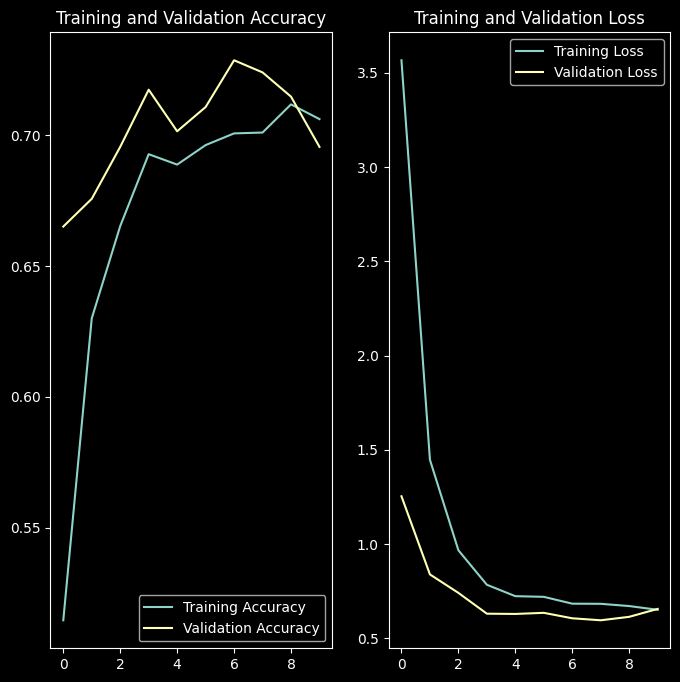

In [99]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

### ResNet101

In [97]:
from tensorflow.keras.applications import ResNet101

In [100]:
input_shape = (img_height, img_width, 3)
base_model = ResNet101(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)

outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 69s 264ms/step - accuracy: 0.5584 - loss: 1.3249 - val_accuracy: 0.6664 - val_loss: 0.6952
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 63s 189ms/step - accuracy: 0.6886 - loss: 0.7681 - val_accuracy: 0.7028 - val_loss: 0.6264
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 35s 187ms/step - accuracy: 0.7098 - loss: 0.6632 - val_accuracy: 0.7134 - val_loss: 0.5961
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 36s 188ms/step - accuracy: 0.7203 - loss: 0.6237 - val_accuracy: 0.7167 - val_loss: 0.6245
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 39s 205ms/step - accuracy: 0.7275 - loss: 0.6024 - val_accuracy: 0.7273 - val_loss: 0.5743
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 36s 188ms/step - accuracy: 0.7249 - loss: 0.6089 - val_accuracy: 0.7187 - val_loss: 0.5801
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 39s 205ms/step - accuracy: 0.7428 - loss: 0.5739 - val_accuracy: 0.7114 - val_loss: 0.6157
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 39s 204ms/step - accuracy: 0.7551 - loss: 0

In [101]:
resnet101 = training_end_time - training_start_time
test_loss, resnet101_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet101_gpu_accuracy:.4f}')
print(f'Training took {resnet101 / 60:.2f} minutes')

59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.7649 - loss: 0.4808
--------------------------------------------------
Test accuracy: 0.7436
Training took 7.10 minutes


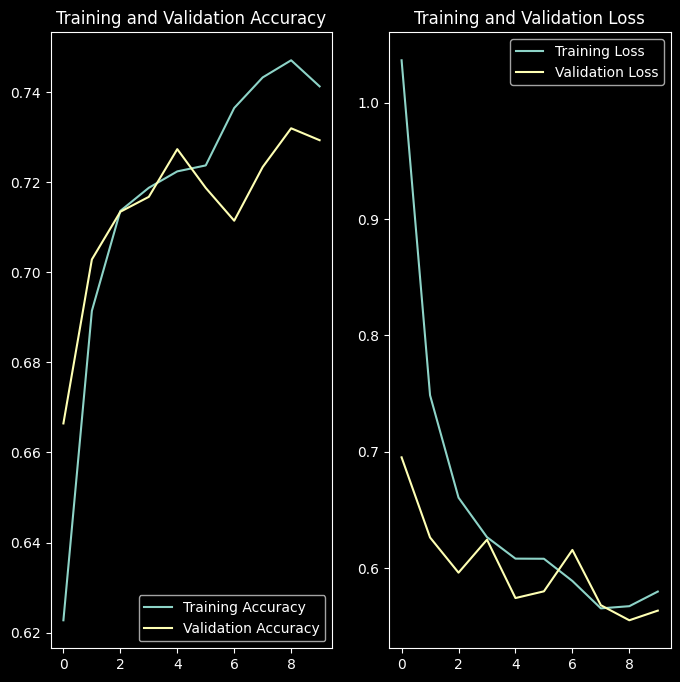

In [102]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

### InceptionV3

In [103]:
from tensorflow.keras.applications import InceptionV3

In [104]:
input_shape = (img_height, img_width, 3)
base_model = InceptionV3(include_top=False,
                         weights='imagenet',
                         input_shape=input_shape)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10)
training_end_time = time.time()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 61s 233ms/step - accuracy: 0.4089 - loss: 24.7749 - val_accuracy: 0.6750 - val_loss: 3.1402
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.5960 - loss: 7.0638 - val_accuracy: 0.6479 - val_loss: 2.9449
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.6036 - loss: 5.0469 - val_accuracy: 0.6565 - val_loss: 2.9572
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.6244 - loss: 4.3110 - val_accuracy: 0.6923 - val_loss: 1.6095
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.6423 - loss: 3.7213 - val_accuracy: 0.6770 - val_loss: 1.6273
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.6425 - loss: 3.3770 - val_accuracy: 0.6903 - val_loss: 1.8197
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.6403 - loss: 3.3740 - val_accuracy: 0.6512 - val_loss: 2.0938
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━

In [105]:
inceptionv3 = training_end_time - training_start_time
test_loss, inceptionv3_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {inceptionv3_gpu_accuracy:.4f}')
print(f'Training took {inceptionv3 / 60:.2f} minutes')

59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7058 - loss: 1.6017
--------------------------------------------------
Test accuracy: 0.6917
Training took 3.68 minutes


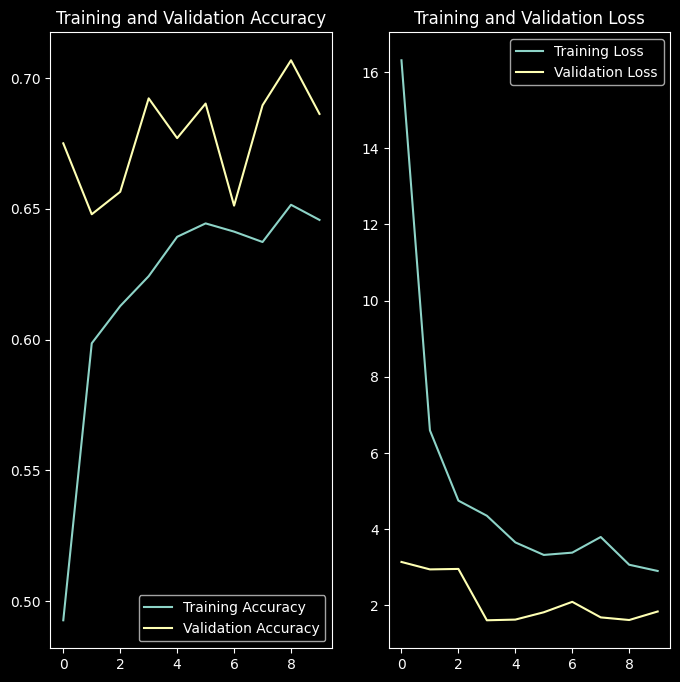

In [106]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

### MobileNet

In [107]:
from tensorflow.keras.applications import MobileNet

In [108]:
input_shape = (img_height, img_width, 3)
base_model = MobileNet(include_top=False,
                       weights='imagenet',
                       input_shape=input_shape)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10)
training_end_time = time.time()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - accuracy: 0.4522 - loss: 1.4735 - val_accuracy: 0.6658 - val_loss: 0.6828
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.6354 - loss: 0.8150 - val_accuracy: 0.7108 - val_loss: 0.5908
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.7055 - loss: 0.6527 - val_accuracy: 0.7419 - val_loss: 0.5510
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.7227 - loss: 0.6089 - val_accuracy: 0.7366 - val_loss: 0.5518
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.7200 - loss: 0.5907 - val_accuracy: 0.7545 - val_loss: 0.5175
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.7296 - loss: 0.5704 - val_accuracy: 0.7452 - val_loss: 0.5210
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.7440 - loss: 0.5554 - val_accuracy: 0.7392 - val_loss: 0.5097
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━

In [109]:
mobilenet = training_end_time - training_start_time
test_loss, mobilenet_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {mobilenet_gpu_accuracy:.4f}')
print(f'Training took {mobilenet / 60:.2f} minutes')

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7864 - loss: 0.4420
--------------------------------------------------
Test accuracy: 0.7812
Training took 1.89 minutes


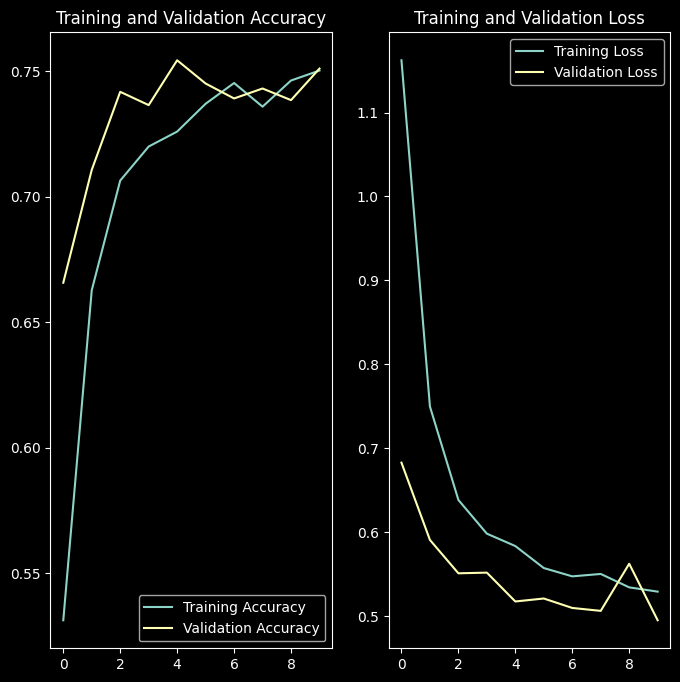

In [110]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

### EfficientNetB0

In [111]:
from tensorflow.keras.applications import EfficientNetB0

In [112]:
input_shape = (img_height, img_width, 3)
base_model = EfficientNetB0(include_top=False,
                       weights='imagenet',
                       input_shape=input_shape)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10)
training_end_time = time.time()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 65s 227ms/step - accuracy: 0.5370 - loss: 1.0278 - val_accuracy: 0.6664 - val_loss: 0.6874
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.6748 - loss: 0.7042 - val_accuracy: 0.6817 - val_loss: 0.6591
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.6925 - loss: 0.6536 - val_accuracy: 0.6883 - val_loss: 0.6291
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.7052 - loss: 0.6321 - val_accuracy: 0.7009 - val_loss: 0.6187
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.7136 - loss: 0.6144 - val_accuracy: 0.6936 - val_loss: 0.6175
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.7235 - loss: 0.5996 - val_accuracy: 0.7081 - val_loss: 0.5907
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.7166 - loss: 0.6114 - val_accuracy: 0.7161 - val_loss: 0.5935
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━

In [113]:
efficientnet = training_end_time - training_start_time
test_loss, efficentnet_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {efficentnet_gpu_accuracy:.4f}')
print(f'Training took {efficientnet / 60:.2f} minutes')

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7593 - loss: 0.5110
--------------------------------------------------
Test accuracy: 0.7511
Training took 2.68 minutes


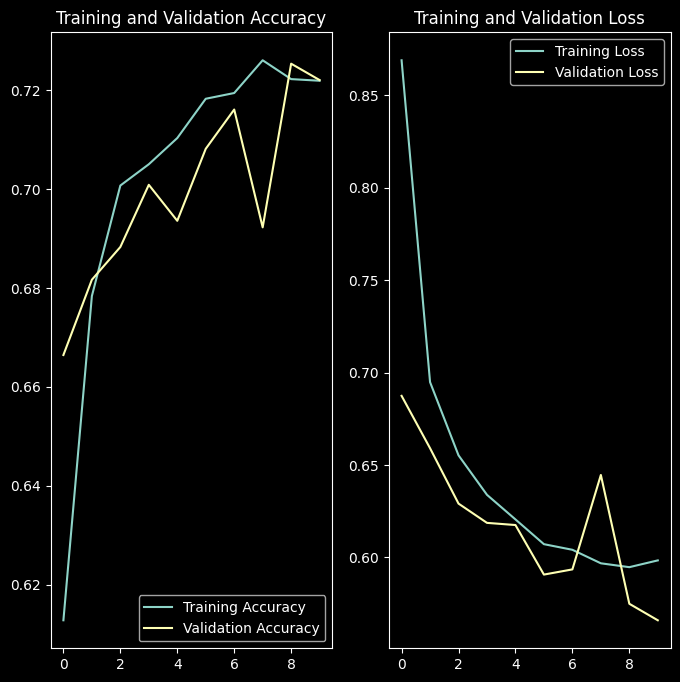

In [114]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()